In [1]:
pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 1.1 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.9 MB/s eta 0:00:0000:0100:01
  Attempting unins

In [2]:
import os
import tifffile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import segmentation_models_pytorch as smp

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
images_path = "/kaggle/input/dataset/data/images"
labels_path = "/kaggle/input/dataset/data/labels"

In [7]:
valid_names = [f"{i}" for i in range(306)]

In [8]:
images = []
labels = []

for name in valid_names:
    img_path = os.path.join(images_path, name + ".tif")
    label_path = os.path.join(labels_path, name + ".png")
    img = tifffile.imread(img_path)
    img = np.transpose(img, (2, 0, 1))
    img = img / img.max()
    img = torch.tensor(img, dtype=torch.float32)
    images.append(img)

    label_path = os.path.join(labels_path, label_path)
    label = Image.open(label_path).convert("L")
    label = np.array(label)                        
    label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
    labels.append(label)

In [9]:
images_ten = torch.stack(images)
labels_ten = torch.stack(labels)

print("Image shape:", images_ten.shape)  
print("Label shape:", labels_ten.shape)  

print("Images type:", type(images_ten))  
print("Labels type:", type(labels_ten))  

Image shape: torch.Size([306, 12, 128, 128])
Label shape: torch.Size([306, 1, 128, 128])
Images type: <class 'torch.Tensor'>
Labels type: <class 'torch.Tensor'>


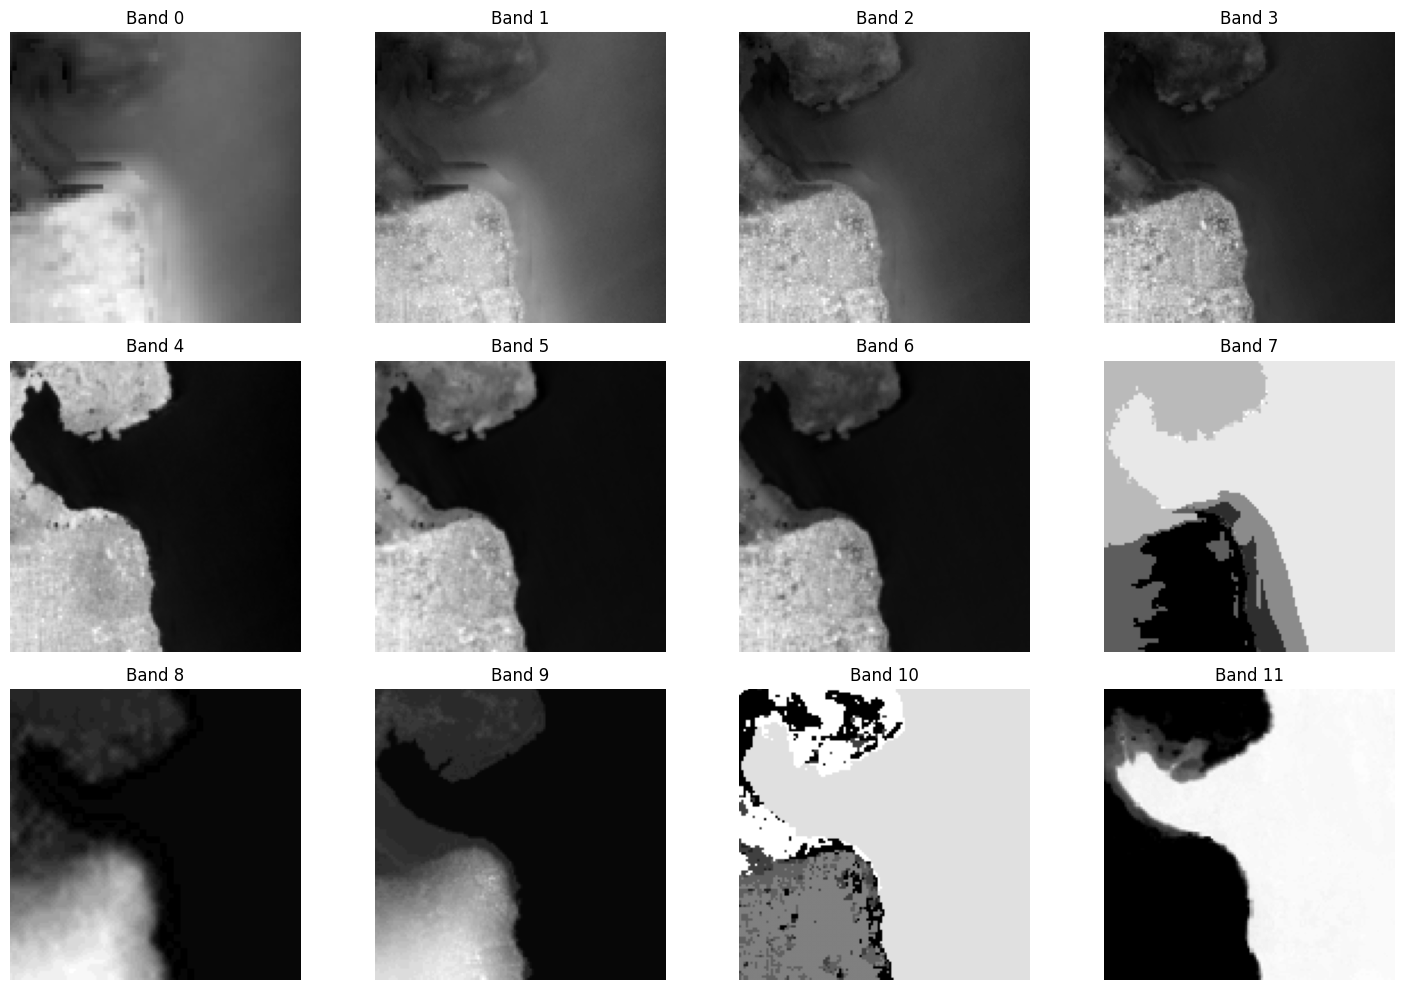

In [10]:
first_image = images_ten[11]

fig, axes = plt.subplots(3, 4, figsize=(15, 10))

for i in range(12):
    ax = axes[i // 4, i % 4]
    
    band = first_image[i]
    ax.imshow(band.numpy(), cmap='gray')
    ax.set_title(f"Band {i}")
    ax.axis('off')

plt.tight_layout()
plt.show()


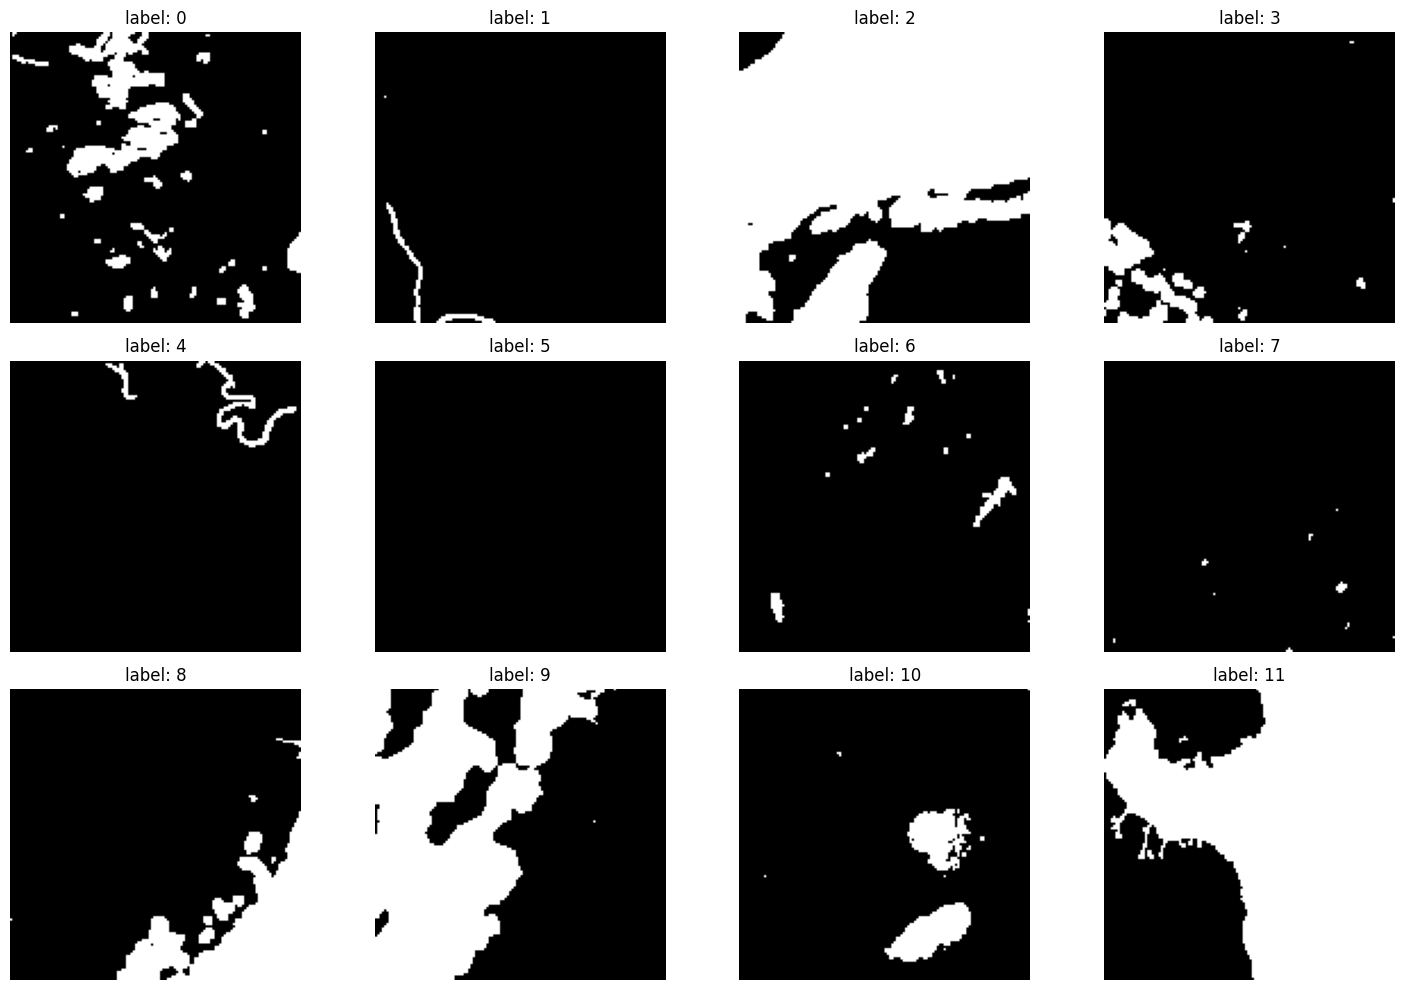

In [11]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))

for i in range(12):
    ax = axes[i // 4, i % 4]
    label = labels_ten[i]    
    label_np = label.squeeze().numpy()
    
    ax.imshow(label_np, cmap='gray')  
    ax.set_title(f"label: {i}")
    ax.axis('off')
    
plt.tight_layout()
plt.show()


In [9]:
# selected_bands = [1, 4, 5, 6, 7, 9] 

# img_ten_selected = images_ten[:, selected_bands, :, :]

In [12]:
img_train, img_val_test, label_train, label_val_test = train_test_split(
    images_ten, labels_ten, test_size=0.3, random_state=42
)

img_val, img_test, label_val, label_test = train_test_split(
    img_val_test, label_val_test, test_size=0.5, random_state=42
)

In [13]:
print(img_train.size())
print(img_val.size())
print(img_test.size())

torch.Size([214, 12, 128, 128])
torch.Size([46, 12, 128, 128])
torch.Size([46, 12, 128, 128])


In [14]:
print(label_train.size())
print(label_val.size())
print(label_test.size())

torch.Size([214, 1, 128, 128])
torch.Size([46, 1, 128, 128])
torch.Size([46, 1, 128, 128])


In [15]:
train_dataset = TensorDataset(img_train, label_train)
val_dataset   = TensorDataset(img_val, label_val)
test_dataset  = TensorDataset(img_test, label_test)

In [16]:
os.makedirs('/kaggle/working/test_images', exist_ok=True)
os.makedirs('/kaggle/working/test_labels', exist_ok=True)


for i in range(len(test_dataset)):
    img, label = test_dataset[i] 

    img_np = img.numpy()  
    tifffile.imwrite(f'/kaggle/working/test_images/{i}.tif', img_np)

    
    label_np = label.squeeze().numpy()
    plt.imsave(f'/kaggle/working/test_labels/{i}.png', label_np, cmap='gray')

In [17]:
import shutil

shutil.make_archive('/kaggle/working/test_images', 'zip', '/kaggle/working/test_images')
shutil.make_archive('/kaggle/working/test_labels', 'zip', '/kaggle/working/test_labels')


'/kaggle/working/test_labels.zip'

In [23]:
train_loader = DataLoader(train_dataset, batch_size=46, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=46)
test_loader  = DataLoader(test_dataset, batch_size=46)

In [15]:
class DoubleConv(nn.Module):
    """(Conv → ReLU) × 2 with same padding"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv (with same padding)"""
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # Pad x1 if needed (just in case shape mismatch)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        if diffY != 0 or diffX != 0:
            x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                            diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    """Final 1×1 Conv Layer"""
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.in_conv = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.out_conv = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.in_conv(x)     # (B, 64, 128, 128)
        x2 = self.down1(x1)      # (B, 128, 64, 64)
        x3 = self.down2(x2)      # (B, 256, 32, 32)
        x4 = self.down3(x3)      # (B, 512, 16, 16)
        x5 = self.down4(x4)      # (B, 1024, 8, 8)
        
        x = self.up1(x5, x4)     # (B, 512, 16, 16)
        x = self.up2(x, x3)      # (B, 256, 32, 32)
        x = self.up3(x, x2)      # (B, 128, 64, 64)
        x = self.up4(x, x1)      # (B, 64, 128, 128)
        logits = self.out_conv(x)  # (B, 1, 128, 128)
        return logits


In [18]:
def plot_metrics(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.show()

In [19]:
def train_model(model, train_loader, val_loader, lr, epochs, flag=0):
    LCE = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, total = 0.0, 0, 0

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            if flag:
                output = model(x_batch)['out']
            else:
                output = model(x_batch)
            loss = LCE(output, y_batch.float())  
            loss.backward()
            optimizer.step()

            predicted = (torch.sigmoid(output) > 0.5).float()
            train_correct += (predicted == y_batch).sum().item()
            train_loss += loss.item() * y_batch.numel()
            total += y_batch.numel()

        train_loss /= total
        train_correct /= total
        train_losses.append(train_loss)
        train_accuracies.append(train_correct)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                if flag:
                    outputs = model(inputs)['out']  
                else:
                    outputs = model(inputs)
                loss = LCE(outputs, labels.float())

                val_loss += loss.item() * labels.numel()
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (predicted == labels).sum().item()
                val_total += labels.numel()

        val_losses.append(val_loss / val_total)
        val_accuracies.append(val_correct / val_total)

        if val_correct / val_total > best_val_acc:
            best_val_acc = val_correct / val_total
            torch.save(model.state_dict(), "/kaggle/working/best_model.pth")

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_losses[-1]:.6f}, Train Acc: {train_accuracies[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.6f}, Val Acc: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


Epoch 1/32, Train Loss: 0.6626, Train Acc: 0.5917, Val Loss: 0.6174, Val Acc: 0.7170
Epoch 2/32, Train Loss: 0.5471, Train Acc: 0.7723, Val Loss: 0.4018, Val Acc: 0.7855
Epoch 3/32, Train Loss: 0.3861, Train Acc: 0.8242, Val Loss: 0.3251, Val Acc: 0.8411
Epoch 4/32, Train Loss: 0.3474, Train Acc: 0.8810, Val Loss: 0.2983, Val Acc: 0.8946
Epoch 5/32, Train Loss: 0.3149, Train Acc: 0.8841, Val Loss: 0.2488, Val Acc: 0.8650
Epoch 6/32, Train Loss: 0.2889, Train Acc: 0.8949, Val Loss: 0.2508, Val Acc: 0.8868
Epoch 7/32, Train Loss: 0.2778, Train Acc: 0.9005, Val Loss: 0.2369, Val Acc: 0.8908
Epoch 8/32, Train Loss: 0.2701, Train Acc: 0.9035, Val Loss: 0.2319, Val Acc: 0.8874
Epoch 9/32, Train Loss: 0.2641, Train Acc: 0.9039, Val Loss: 0.2320, Val Acc: 0.9403
Epoch 10/32, Train Loss: 0.2649, Train Acc: 0.9030, Val Loss: 0.2342, Val Acc: 0.9049
Epoch 11/32, Train Loss: 0.2600, Train Acc: 0.9045, Val Loss: 0.2289, Val Acc: 0.9092
Epoch 12/32, Train Loss: 0.2550, Train Acc: 0.9038, Val Loss: 0

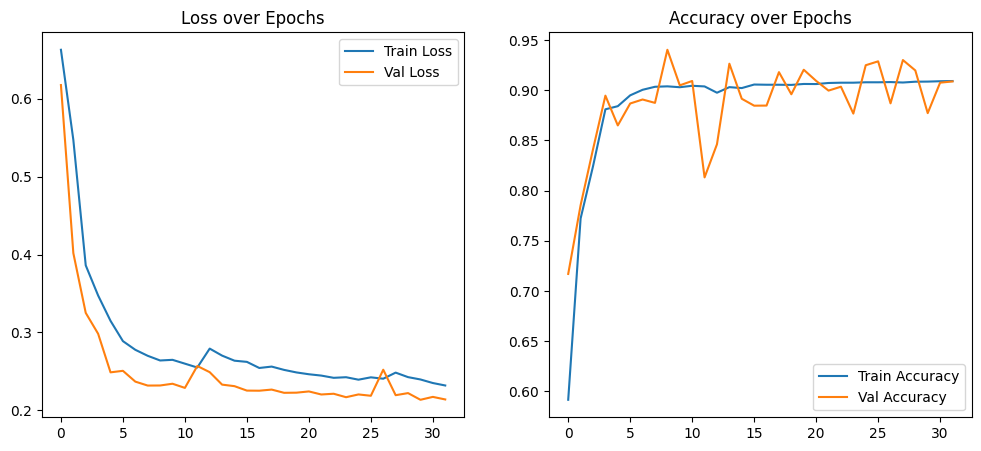

In [18]:
model = UNet(n_channels=12, n_classes=1).to(device)
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, 0.001, epochs=32)
plot_metrics(train_loss, val_loss, train_acc, val_acc)

In [20]:
def evaluate(model, loader, flag=0):
    model.eval()
    correct, total = 0, 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            if flag:
                outputs = model(inputs)['out']
            else:
                outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels.bool()).sum().item()
            total += labels.numel()

            all_preds.append(preds.view(-1).cpu())   # y_true → shape: [N]     (1D vector)
            all_labels.append(labels.view(-1).cpu()) # y_pred → shape: [N]
                                                     # as metrics like precision, recall, F1, and IoU from sklearn.metrics expect

    y_pred = torch.cat(all_preds).numpy()  # Combine predictions across all batches
    y_true = torch.cat(all_labels).numpy() # Required because sklearn needs NumPy arrays

    precision = precision_score(y_true, y_pred, pos_label=1) # Of all predicted water pixels, how many were correct?
    recall    = recall_score(y_true, y_pred, pos_label=1) # Of all actual water pixels, how many did the model find?
    f1        = f1_score(y_true, y_pred, pos_label=1)  # Harmonic mean of precision & recall (balance)
    iou       = jaccard_score(y_true, y_pred, pos_label=1) # Intersection over Union (how much the prediction overlaps the ground truth)

    print("Evaluation Metrics (Water class = 1):")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"IoU      : {iou:.4f}")
    print(f"Test Accuracy: {correct / total:.4f}")
    
    return correct / total


In [20]:
model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))

<All keys matched successfully>

In [21]:
test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Evaluation Metrics (Water class = 1):
Precision: 0.9441
Recall   : 0.6603
F1-score : 0.7771
IoU      : 0.6354
Test Accuracy: 0.8805


# **Transfer Learning**

In [61]:
model = smp.Unet(
    encoder_name="densenet169",    
    encoder_weights="imagenet",    
    in_channels=12,                 
    classes=1                      
)

for param in model.encoder.parameters():
    param.requires_grad = False
for param in model.decoder.parameters():
    param.requires_grad = True

Epoch 1/50, Train Loss: 0.228356, Train Acc: 0.9569, Val Loss: 0.285295, Val Acc: 0.9182
Epoch 2/50, Train Loss: 0.233806, Train Acc: 0.9535, Val Loss: 0.294641, Val Acc: 0.9140
Epoch 3/50, Train Loss: 0.221935, Train Acc: 0.9576, Val Loss: 0.281027, Val Acc: 0.9171
Epoch 4/50, Train Loss: 0.215930, Train Acc: 0.9607, Val Loss: 0.275655, Val Acc: 0.9190
Epoch 5/50, Train Loss: 0.214092, Train Acc: 0.9598, Val Loss: 0.267270, Val Acc: 0.9219
Epoch 6/50, Train Loss: 0.210890, Train Acc: 0.9601, Val Loss: 0.273193, Val Acc: 0.9171
Epoch 7/50, Train Loss: 0.200595, Train Acc: 0.9646, Val Loss: 0.282839, Val Acc: 0.9108
Epoch 8/50, Train Loss: 0.199257, Train Acc: 0.9636, Val Loss: 0.275628, Val Acc: 0.9145
Epoch 9/50, Train Loss: 0.192701, Train Acc: 0.9658, Val Loss: 0.266712, Val Acc: 0.9181
Epoch 10/50, Train Loss: 0.190633, Train Acc: 0.9660, Val Loss: 0.265857, Val Acc: 0.9182
Epoch 11/50, Train Loss: 0.190988, Train Acc: 0.9643, Val Loss: 0.263609, Val Acc: 0.9176
Epoch 12/50, Train 

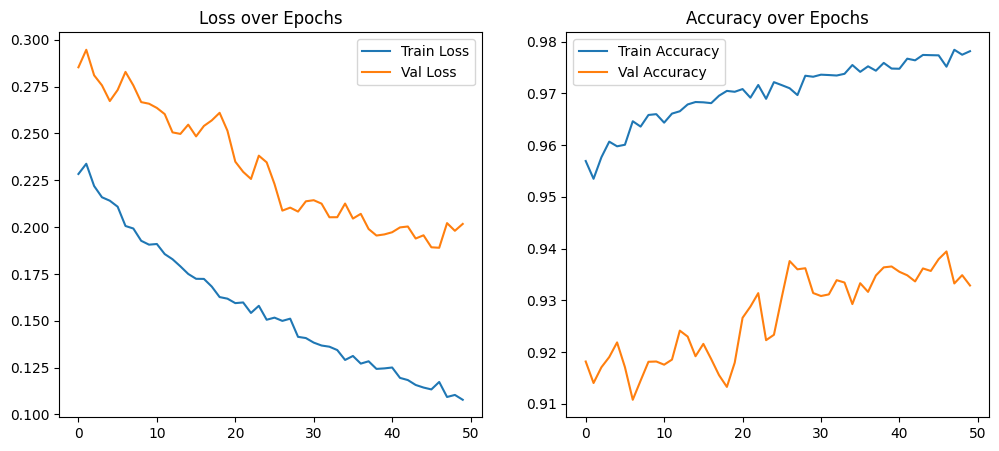

In [27]:
model = model.to(device)
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, 0.0001, epochs=50)
plot_metrics(train_loss, val_loss, train_acc, val_acc)

In [62]:
model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))

<All keys matched successfully>

In [65]:
model = model.to(device)

test_acc = evaluate(model, test_loader)

Evaluation Metrics (Water class = 1):
Precision: 0.9133
Recall   : 0.8346
F1-score : 0.8722
IoU      : 0.7733
Test Accuracy: 0.9228


In [46]:
from torchvision.models.segmentation import deeplabv3_resnet50

model = deeplabv3_resnet50(pretrained=True)
model.backbone.conv1 = nn.Conv2d(12, 64, kernel_size=7, stride=2, padding=3, bias=False)

model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Train Loss: 0.688619, Train Acc: 0.5305, Val Loss: 0.918889, Val Acc: 0.2834
Epoch 2/50, Train Loss: 0.531725, Train Acc: 0.8138, Val Loss: 2.094789, Val Acc: 0.2850
Epoch 3/50, Train Loss: 0.432734, Train Acc: 0.8582, Val Loss: 1.594346, Val Acc: 0.3885
Epoch 4/50, Train Loss: 0.367297, Train Acc: 0.8842, Val Loss: 0.979002, Val Acc: 0.6437
Epoch 5/50, Train Loss: 0.328731, Train Acc: 0.8925, Val Loss: 0.393060, Val Acc: 0.8551
Epoch 6/50, Train Loss: 0.299779, Train Acc: 0.8991, Val Loss: 0.312363, Val Acc: 0.8872
Epoch 7/50, Train Loss: 0.278719, Train Acc: 0.9080, Val Loss: 0.275921, Val Acc: 0.9043
Epoch 8/50, Train Loss: 0.266279, Train Acc: 0.9111, Val Loss: 0.266446, Val Acc: 0.9084
Epoch 9/50, Train Loss: 0.256026, Train Acc: 0.9151, Val Loss: 0.259563, Val Acc: 0.9090
Epoch 10/50, Train Loss: 0.250185, Train Acc: 0.9150, Val Loss: 0.255473, Val Acc: 0.9093
Epoch 11/50, Train Loss: 0.249058, Train Acc: 0.9160, Val Loss: 0.254823, Val Acc: 0.9090
Epoch 12/50, Train 

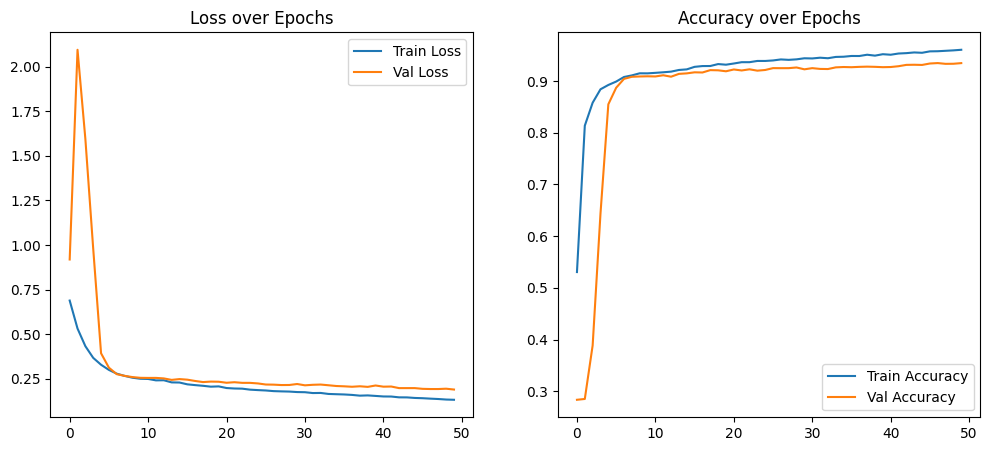

In [47]:
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, 0.0001, epochs=50, 1)
plot_metrics(train_loss, val_loss, train_acc, val_acc)

In [49]:
model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))

<All keys matched successfully>

In [50]:
test_acc = evaluate(model, test_loader, 1)
print(f"Test Accuracy: {test_acc:.4f}")

Evaluation Metrics (Water class = 1):
Precision: 0.9276
Recall   : 0.8030
F1-score : 0.8608
IoU      : 0.7557
Test Accuracy: 0.9181


In [69]:
model = smp.Unet(
    encoder_name="densenet169",
    encoder_weights="imagenet",
    in_channels=12,
    classes=1
)
model.load_state_dict(torch.load("/kaggle/input/weights/best_model_transfer.pth", map_location=device))


<All keys matched successfully>

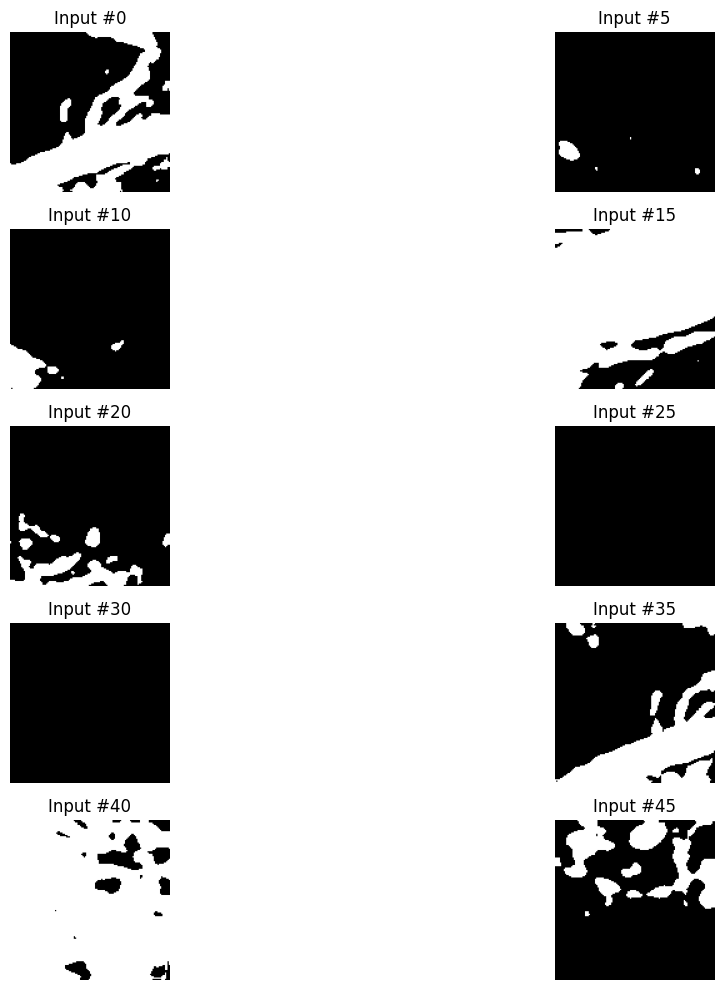

In [76]:
c = 0
i = 0
fig, axes = plt.subplots(5, 2, figsize=(15, 10))

model.eval()
with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(test_loader):
        output = model(inputs)
        preds = (torch.sigmoid(output) > 0.5).squeeze().cpu().numpy().astype(np.uint8)

        for pred_idx, pred in enumerate(preds):
            if c%5==0:
                ax = axes[i // 2, i % 2] 
                input_number = batch_idx * test_loader.batch_size + pred_idx
                ax.imshow(pred, cmap='gray')
                ax.set_title(f"Input #{input_number}")
                ax.axis('off')
                i+=1
            c += 1
            
plt.tight_layout()
plt.show()

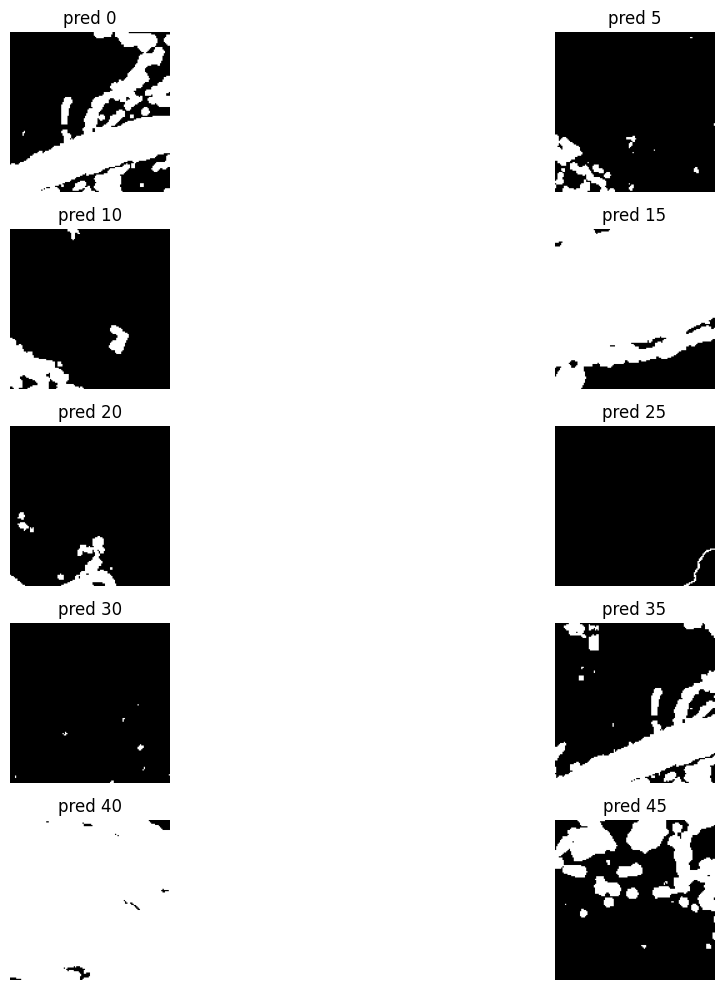

In [79]:
c = 0
i = 0
fig, axes = plt.subplots(5, 2, figsize=(15, 10))

model.eval()
with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(test_loader):
        for label_idx, label in enumerate(labels):
            if c%5==0:
                ax = axes[i // 2, i % 2] 
                label = label.squeeze().cpu().numpy().astype(np.uint8)
                ax.imshow(label, cmap='gray')
                ax.set_title(f"pred {c}")
                ax.axis('off')
                i+=1
            c += 1
            
plt.tight_layout()
plt.show()